# Rotterdam stylized case

In [1]:
from classes import *
import copy
from collections import OrderedDict
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
#import ipywidgets as widgets
#import pickle

# Build the model (components of the city)

### Define a default damage curve

In [2]:
#From Excel Huizinga et al. (2017) JRC Glboal flood-depth damage function Excel - tab MaxDamage-residential
#2010 price levels, The Netherlands
MaxDamage_Residential = { 
    'Building_based' : { 'Structure' : 561,  'Content' : 281,    'Total' : 842}, #euro/m2
    'Land-use_based' : 168, #euro/m2
    'Object_based' : 84175 }#euro/house? 

#Tab Damage functions DamCurve_Residential_buildings
depth = [0,0.5,1,1.5,2,3,4,5,6] #depth in meter
dam_frac = [0,0.25,0.4,0.5,0.6,0.75,0.85,0.95,1.00] #damage fraction (-)

dam_pars= (MaxDamage_Residential['Land-use_based'],depth,dam_frac) #all parameters for the damage assessment

In [3]:
Rotty = Model('Rotty')
#Add residential areas to the model
Rotty.add_ResidentialArea(ResidentialArea("Area_A",4,1*1,dam_pars,["No"],"Residential area A: the Heijplaat"))
Rotty.add_ResidentialArea(ResidentialArea("Area_B",1,5*5,dam_pars,["Dike"],"Residential area B: City Centre"))

#Add flood protection objections to the model
Rotty.add_FloodProtection(FloodProtection("No",4,False,"Region without flood protection"))
Rotty.add_FloodProtection(FloodProtection("Dike",4.5,False,"Sea dike"))

Rotty.add_Parameter("alarming_conditions",
       OrderedDict({ #water depth above flood protection level, Name of event, reduction of trust if this happens.
                2   : ['Major flood',40], 
                1   : ['Small flood',20],
                0   : ['Near miss',10],
                -0.5  : ['Major wake-up',7],
                -1  : ['Minor wake-up',5],
                -10  : ['Nothing happens',0]}))

#ADD THE MEASURES THAT CAN BE TAKEN
Rotty.add_Measure_FloodProtection(Measure_FloodProtection("Minor Dike Heightening", 7, 0.5))
Rotty.add_Measure_FloodProtection(Measure_FloodProtection("Major Dike Heightening", 12, 1))

In [4]:
Rotty.allResidentialArea[0].__dict__

{'name': 'Area_A',
 'elevation': 4,
 'surface_area': 1,
 'dam_pars': (168,
  [0, 0.5, 1, 1.5, 2, 3, 4, 5, 6],
  [0, 0.25, 0.4, 0.5, 0.6, 0.75, 0.85, 0.95, 1.0]),
 'protected_by': ['No'],
 'description': 'Residential area A: the Heijplaat',
 'trust_0': 70}

In [5]:
Rotty

Rotty 
-----------
allFloodProtection: 
No 4; Dike 4.5;  
-----------
allResidentialArea: 
Area_A Protected by:['No']
Area_B Protected by:['Dike']

Parameters : 
{'alarming_conditions': OrderedDict([(2, ['Major flood', 40]), (1, ['Small flood', 20]), (0, ['Near miss', 10]), (-0.5, ['Major wake-up', 7]), (-1, ['Minor wake-up', 5]), (-10, ['Nothing happens', 0])])}

### Load storm surge scenarios

In [6]:
SurgeSeries_A = SurgeSeries(allSurgeSeries,"A",'Scenario A: lower part of RCP4.5',None,None) #Je kunt allSurgeSeries ook gewoon bijhouden in de classes.py
SurgeSeries_B = SurgeSeries(allSurgeSeries,"B",'Scenario B: middle of RCP4.5',None,None)
SurgeSeries_C = SurgeSeries(allSurgeSeries,"C",'Scenario C: middle of RCP8.5',None,None)
SurgeSeries_D = SurgeSeries(allSurgeSeries,"D",'Scenario D: upper part of RCP8.5',None,None)
SurgeSeries_A.from_csv("A.csv")
SurgeSeries_B.from_csv("B.csv")
SurgeSeries_C.from_csv("C.csv")
SurgeSeries_D.from_csv("D.csv")

# Define adaptation strategies (Mayors)

In [7]:
class Kroket(Mayor):
    """
    Reactive management strategy:
    In case of near miss: implements a Small dike heightening
    In case of a flood event: implements a Large dike heightening
    
    """
    
    def apply_strategy(self,Model,SurgeSeries,i,time):
        
        #STRATEGY FOR THE OUTERDIKE AREA
        #TODO
        
        #STRATEGY FOR THE CITY CENTRE
        CC = Model.allResidentialArea[1]
        FloodProtection = Model.allFloodProtection[1] #the object to which to apply the heightening
        
        #ONLY CONSIDER IMPLEMENTING A NEW MEASURE IF THE OLD ONE HAS NOT YET BEEN FINISHED
        if FloodProtection.underconstruction == 0:
            if CC.event_impact_history[i] == 10:
                Measure = Model.allMeasures[0] #small dike heightening
                FloodProtection.measure_history[i] = Measure.heightening #track the increase of the object
                FloodProtection.update_protection_level(start=i+Measure.lead_time,
                                                        end=len(time),
                                                        newvalue=FloodProtection.protection_level[i]+Measure.heightening,
                                                        lead_time = Measure.lead_time) 

            if CC.event_impact_history[i] > 20:
                Measure = Model.allMeasures[1] #large dike heightening
                FloodProtection.measure_history[i] = Measure.heightening #track the increase of the object
                FloodProtection.update_protection_level(start=i+Measure.lead_time,
                                                        end=len(time),
                                                        newvalue=FloodProtection.protection_level[i]+Measure.heightening,
                                                        lead_time = Measure.lead_time) 
      
    def get_name(self):
        return('Berry Kroket')
    
class Bob(Mayor):
    """
    Proactive management strategy:
    In case of a minor wake-up: implements Small dike heightening
    In case of a flood event: implements Large dike heightening
    """
    
    def apply_strategy(self,Model,SurgeSeries,i,time):
        #STRATEGY FOR THE OUTERDIKE AREA
        #TODO

        #STRATEGY FOR THE CITY CENTRE
        CC = Model.allResidentialArea[1]
        FloodProtection = Model.allFloodProtection[1] #the object to which to apply the heightening
        
        if FloodProtection.underconstruction == 0:           
            if CC.event_impact_history[i] == 5:
                Measure = Model.allMeasures[0] #small dike heightening
                FloodProtection.measure_history[i] = Measure.heightening #track the increase of the object
                FloodProtection.update_protection_level(start=i+Measure.lead_time,
                                                            end=len(time),
                                                            newvalue=FloodProtection.protection_level[i]+Measure.heightening,
                                                            lead_time = Measure.lead_time) 
            if CC.event_impact_history[i] > 7:
                Measure = Model.allMeasures[1] #large dike heightening
                FloodProtection.measure_history[i] = Measure.heightening #track the increase of the object
                FloodProtection.update_protection_level(start=i+Measure.lead_time,
                                                            end=len(time),
                                                            newvalue=FloodProtection.protection_level[i]+Measure.heightening,
                                                            lead_time = Measure.lead_time) 
    def get_name(self):
        return('Bob the Builder')

    
allMayors = [Kroket(),Bob()]

In [8]:
def run_model(Model,SurgeSeries,Mayor):
    time = SurgeSeries.years
    
    #GET MODEL PARAMETERS
    alarming_conditions = Model.Parameters['alarming_conditions']
    
    #TODO ADD THIS FUNCTIONALITY TO THE FLOODPROTECTIONCLASS
    for FloodProtection in Model.allFloodProtection:
        FloodProtection.protection_level = [FloodProtection.baseline_level] * len(time)
        FloodProtection.measure_history = [0] * len(time)                

    for Area in Model.allResidentialArea:
        Area.match_with_FloodProtection(Model.allFloodProtection) #ADD THE INFORMATION OF THE FLOOD PROTECTION STRUCTURES TO THE AREAS IT PROTECTS
        Area.init_time(time) #create all the variables that are manipulated over time

    # THE MODEL RUNS OVER A YEARLY TIMESTEP
    for i,t in enumerate(time): #Iterate over the years t, with index i
        #print(i,t)

        for FloodProtection in Model.allFloodProtection:
            FloodProtection.construction_progress() #withdraw 1 year from the construction progress
        
        for Area in Model.allResidentialArea:
            #FIRST EVALUATE IF THE FLOOD PROTECTION LEVEL IS EXCEEDED (TO DETERMINE IF FLOOD HAPPENS)
            if Area.protection_level[i] < SurgeSeries.surgelevel[i]: #if a flood occurs
                Area.flood_history[i] = SurgeSeries.surgelevel[i] - Area.elevation
                #print("{} is inundated with a water depth of {} m \n --> damage occurs".format(Area.name,Area.flood_history[i]))

            #THEN EVALUATE THE IMPACT ON TRUST
            if i != 0: #don't evaluate trust in the first timestep!
                #print(Area.protection_level-levels_t[i])
                Area.event_impact_history[i] = evaluate_event(SurgeSeries.surgelevel[i]-Area.protection_level[i],alarming_conditions,False)
                #First evaluate the impact of this year's event (if any)

                Area.trust_t[i] = Area.trust_t[i-1] - Area.event_impact_history[i]

                #ALWAYS MODEL RECOVERY OF TRUST
                k = 0.2 #bovenaan definieren
                T_eq = 70
                dTdt = (Area.trust_t[i]-T_eq)*-k
                Area.trust_t[i] = Area.trust_t[i] + dTdt

        #IMPLEMENT FLOOD PROTECTION MEASURES
        Mayor.apply_strategy(Model,SurgeSeries,i,time)
        
        for Area in Model.allResidentialArea:
               Area.match_with_FloodProtection(Model.allFloodProtection)
    
    #RETURN OUTCOMES OF THE MODEL
    experiment = OrderedDict({
        "model_name" : Model.name,
        "Model" : copy.deepcopy(Model),
        "SurgeSeries" : copy.deepcopy(SurgeSeries),
        "Mayor" : copy.deepcopy(Mayor)
    })
    
    return experiment

experiments = []
for SurgeSeries in allSurgeSeries:
    experiment = run_model(Rotty,SurgeSeries,Kroket())
    experiments.append(experiment)

In [9]:
len(experiments)

4

D
C
B
A


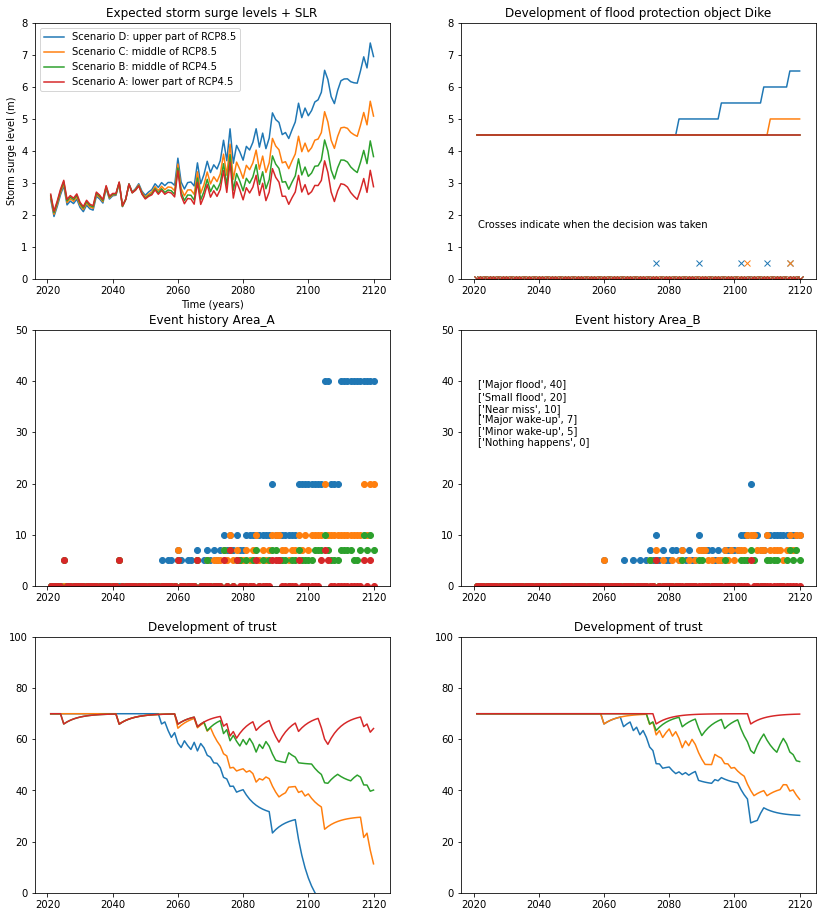

In [10]:
fig, axes = plt.subplots(nrows=3,ncols=2,sharey=False,figsize=(14,16))

labels = []

for experiment in reversed(experiments):
    
    Model = experiment['Model']
    SurgeSeries = experiment['SurgeSeries']
    Mayor = experiment['Mayor']
    
    print(SurgeSeries.name)
    
    axes[0,0].plot(SurgeSeries.years,SurgeSeries.surgelevel)

    labels.append(SurgeSeries.description)
    axes[0,0].set_title('Expected storm surge levels + SLR')
    axes[0,0].set_xlabel('Time (years)')
    axes[0,0].set_ylabel('Storm surge level (m)')
    axes[0,0].set_ylim(0,8)
    axes[0,1].set_ylim(0,8)

    for i, Area in enumerate(Model.allResidentialArea):
        axes[1,i].set_title('Event history {}'.format(Model.allResidentialArea[i].name))
        axes[1,i].plot(SurgeSeries.years,Model.allResidentialArea[i].event_impact_history,'o')
        axes[1,i].set_ylim(0,50)
        
        axes[2,i].set_title('Development of trust')
        axes[2,i].plot(SurgeSeries.years,Model.allResidentialArea[i].trust_t)

        axes[2,i].set_ylim(0,100)
    

    axes[0,1].plot(SurgeSeries.years,Model.allFloodProtection[1].protection_level)
    axes[0,1].set_title('Development of flood protection object Dike')
    
axes[0,0].legend(labels)

#Add some additional text to some axes
alarming_conditions = Model.Parameters['alarming_conditions']

textbox = ""
for key in alarming_conditions:
    textbox = textbox + str(alarming_conditions[key]) + '\n'

axes[0,1].text(0.05,0.2,"Crosses indicate when the decision was taken",transform=axes[0,1].transAxes)
axes[1,1].text(0.05,0.5,textbox,transform=axes[1,1].transAxes)


axes[0,1].set_prop_cycle(None) #reset the cycler to plot again in the same axes with similar colors
for experiment in reversed(experiments):
    Model = experiment['Model']
    SurgeSeries = experiment['SurgeSeries']
    Mayor = experiment['Mayor']    
    
    axes[0,1].plot(SurgeSeries.years,Model.allFloodProtection[1].measure_history,'x') #PLOT THE HISTORY OF THE MEASURES
    

### Huizinga (2017) Damage function Residential Area


In [11]:
def calculate_damage_area(dam_pars,inundation,surface_area):
    """
    Calculate damage for a residential area
    
    Input:
        *pars* (tuple) : (MaxDamage_Residential,depth,dam_frac) describing damage functions
                              euro/m2            m      (-)
        *inundation* (float) : Inundation depth in m
        *surface_area* (float) : Surface area of the region in km2
        
    Returns:
        *damage* (float) : damage to the area in 2010-Euros
    """
    dam_fraction = np.interp(inundation,dam_pars[1],dam_pars[2]) #fraction of max damage
    max_damage = dam_pars[0]
    return int(round(max_damage * 10**6 * surface_area))
    
calculate_damage_area(dam_pars,10,100)


16800000000